# Demonstrations of improved recovery with regularization, constraints, and modified model parameterization

We show simple examples of Pogit models that demonstrate how regularizers, constraints, and different link functions can improve our estimation of p and lambda

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xspline import XSpline
from regmod.data import Data
from regmod.variable import Variable, SplineVariable
from regmod.prior import SplineUniformPrior, SplineGaussianPrior, LinearGaussianPrior
from regmod.models import PogitModel
from regmod.utils import SplineSpecs
from regmod.optimizer import scipy_optimize

In [2]:
def logit(p):
    return np.log(p/(1-p))

In [3]:
np.random.seed(123)
NUM_OBS = 500
N_TRIALS = 50

## Unconstrained Model
Generate data according to `logit(p) = -sin(2\pi x0)` and `log(lambda) = cos(2\pi x1)` with `x0, x1 ~ Uniform(0,1)`. Over many realizations of the data, fit the model and illustrate the poor recovery.

In [4]:
# Set up x-axis values for plotting the results (global variables)
X0_PRED = np.linspace(0, 1, 100)
X1_PRED = np.linspace(0, 1, 100)

In [5]:
# Set up variables for the model
def var0_gen_unconstrained(x0):
    # Note, this function doesn't use x0, but it will be used in the future
    var0 = SplineVariable(name="x0",
                          spline_specs=SplineSpecs(knots=np.array([0.0, 0.25, 0.75, 1.0]),
                                                   knots_type="abs",
                                                   degree=3))

    return var0

def var1_gen_unconstrained(x1):
    var1 = SplineVariable(name="x1",
                          spline_specs=SplineSpecs(knots=np.array([0.0, 0.5, 1.0]),
                                                   knots_type="abs",
                                                   degree=3))
    return var1

In [6]:
def generateData():
    x0 = np.random.rand(NUM_OBS)
    x1 = np.random.rand(NUM_OBS)

    true_p = 1.0/(1.0 + np.exp(-np.sin(x0*2.0*np.pi)))
    true_lam = 15.0 + np.exp(np.cos(x1*2.0*np.pi))
    n = np.random.poisson(true_lam)
    y = np.random.binomial(n=n, p=true_p)
    
    return x0, x1, y, n

def fitModel(var0_gen, var1_gen, pOptions={}):
    df_pred = pd.DataFrame({"x0": X0_PRED, "x1": X1_PRED})
    data_pred = Data(col_covs=["x0", "x1"], df=df_pred)

    pred0 = np.zeros((len(X0_PRED), N_TRIALS))
    pred1 = np.zeros((len(X1_PRED), N_TRIALS))

    for i in range(N_TRIALS):
        # Generate data (don't even look at true n)
        x0, x1, y, _ = generateData()

        # Build and fit model
        df = pd.DataFrame({"y": y, "x0": x0, "x1": x1})
        data = Data(col_obs="y", col_covs=["x0", "x1"], df=df)
        var0 = var0_gen(x0)
        var1 = var1_gen(x1)
        pOptions['variables'] = [var0]
        model = PogitModel(data, param_specs={"p": pOptions, "lam": {"variables": [var1]}})
        result = scipy_optimize(model)

        # Record the estimated pHat and lambdaHat at every value of x0, x1
        coefs = model.split_coefs(result["coefs"])

        pred0[:,i] = model.params[0].get_param(coefs[0], data_pred)
        pred1[:,i] = model.params[1].get_param(coefs[1], data_pred)
    
    return pred0, pred1

In [7]:
unconstrainedPred0, unconstrainedPred1 = fitModel(var0_gen_unconstrained, var1_gen_unconstrained)

In [8]:
# Plot the pHat, lamHat, and muHat estimates from each trial
def plotTrials(pred0, pred1, ax=None, titleString=""):
    # Generate one round of data just so we can plot it and see what representative data looks like
    x0, x1, y, n = generateData()
    
    multiplot = True
    if ax is None:
        multiplot = False
        fig, ax = plt.subplots(3, 1, figsize=(10, 5*3))
    ax[0].scatter(x0, y/n, marker=".", color="gray", alpha=0.5, s=3)
    ax[0].plot(X0_PRED, pred0, color="#008080", label=["one model fit"] + ["_nolabel_"]*(N_TRIALS-1), alpha=0.2)
    ax[0].plot(X0_PRED, 1.0/(1.0 + np.exp(-np.sin(X0_PRED*2.0*np.pi))), color="#DC143C", label="true", linestyle="--")
    ax[0].set_xlabel("x0")
    ax[0].set_ylabel("p ~ y/n")
    ax[0].set_title("Pogit Model"+titleString, loc="left")
    ax[0].legend()

    ax[1].semilogy(X1_PRED, pred1, color="#008080", label=["one model fit"] + ["_nolabel_"]*(N_TRIALS-1), alpha=0.2)
    ax[1].plot(X1_PRED, 15.0 + np.exp(np.cos(X1_PRED*2.0*np.pi)), color="#DC143C", label="true", linestyle="--")
    ax[1].scatter(x1, n, marker=".", color="gray", alpha=0.5, s=3)
    ax[1].set_xlabel("x1")
    ax[1].set_ylabel("lam ~ n")
    ax[1].legend()

    ax[2].scatter(x0, y, marker=".", color="gray")
    ax[2].plot(X0_PRED, pred0*pred1, color="#008080", label=["one model fit"] + ["_nolabel_"]*(N_TRIALS-1), alpha=0.2)
    ax[2].plot(X0_PRED, (15.0 + np.exp(np.cos(X1_PRED*2.0*np.pi)))/(1.0 + np.exp(-np.sin(X0_PRED*2.0*np.pi))), color="#DC143C", label="true", linestyle="--")
    ax[2].set_xlabel("x0, x1")
    ax[2].set_ylabel("p*lam ~ y")
    ax[2].legend()
    
    if not multiplot:
        plt.show()

In [9]:
def plotComparison(predList, saveFile=None, subplotDims=(7,5)):
    """predList is a list of (pred0, pred1, titleString) tuples"""
    nComparators = len(predList)
    subplot_w, subplot_h = subplotDims
    fig, ax = plt.subplots(3, nComparators, figsize=(subplot_w*nComparators, subplot_h*3), sharey='row')
    for i, (pred0, pred1, titleString) in enumerate(predList):
        plotTrials(pred0, pred1, ax[:,i], titleString)
    if saveFile is not None:
        plt.savefig(saveFile, bbox_inches="tight")
    plt.show()

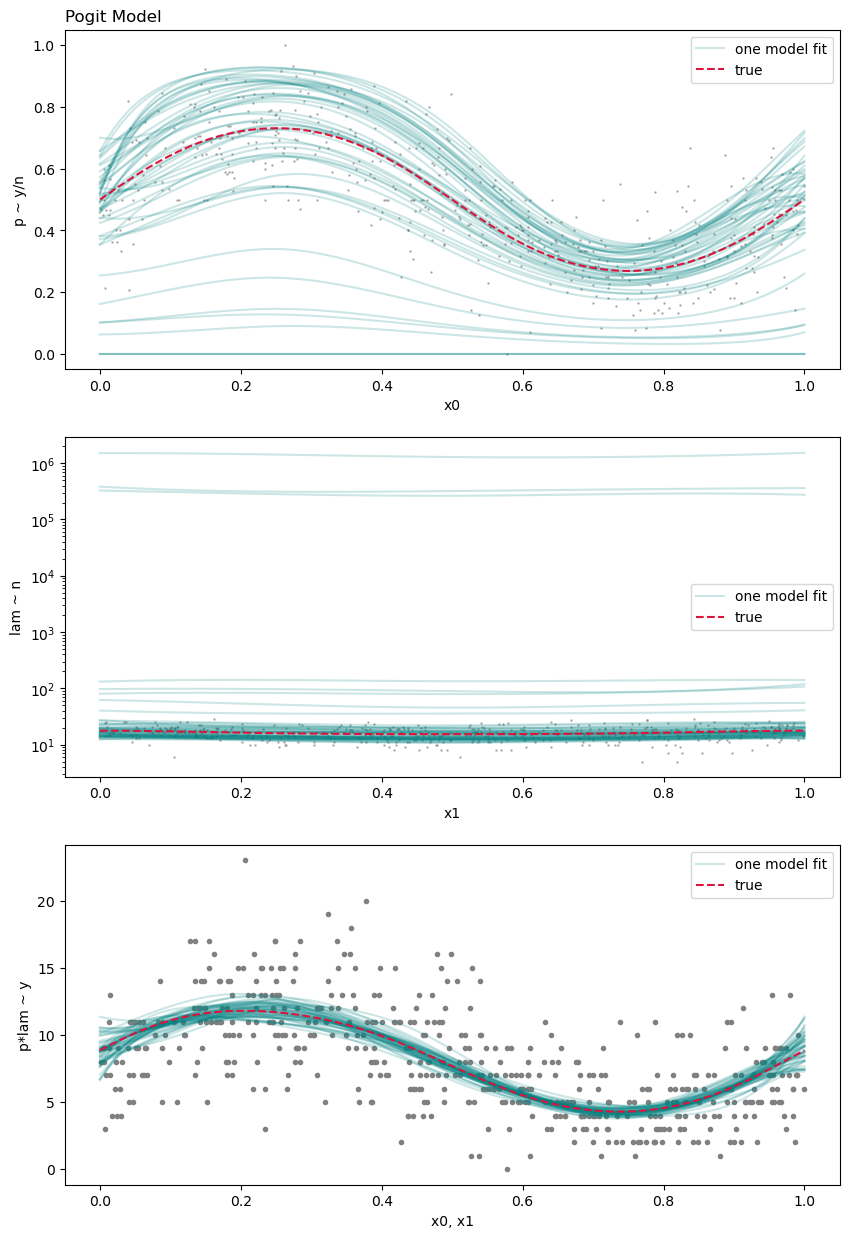

In [10]:
plotTrials(unconstrainedPred0, unconstrainedPred1)

## Technique 1: Quadratic Regularizers (Gaussian Priors)

Suppose we knew the average p was about 1/2 over the entire range of `x0` - if we regularize toward that, we can improve our recovery of p and lambda

In [11]:
# Set up variables for the model
def var0_gen_regularized(x0):
    # Build a new x0 variable that regularizes p toward 1/2
    avgX0 = np.mean(x0)
    avgP_guess = 0.5
    sd = 0.3  # This sd is in logit space; the logit of 0.5 is 0. An sd of 0.3 gives +/- 1 sd as (0.42, 0.57)
    
    spline = XSpline(knots=np.array([0.0, 0.25, 0.75, 1.0]), degree=3)
    #a, b = spline.knots[0], spline.knots[-1]
    
    #mat = spline.design_imat(a, b, order=1)/(b - a)
    mat = np.mean(spline.design_mat(x0), axis=0)[None, :]
    gaussian_prior_avgP = LinearGaussianPrior(mat=mat, mean=logit(avgP_guess), sd=sd)
    
    var0 = SplineVariable(name="x0", spline=spline, linear_gpriors=[gaussian_prior_avgP])
    return var0

In [12]:
regularizedPred0, regularizedPred1 = fitModel(var0_gen_regularized, var1_gen_unconstrained)

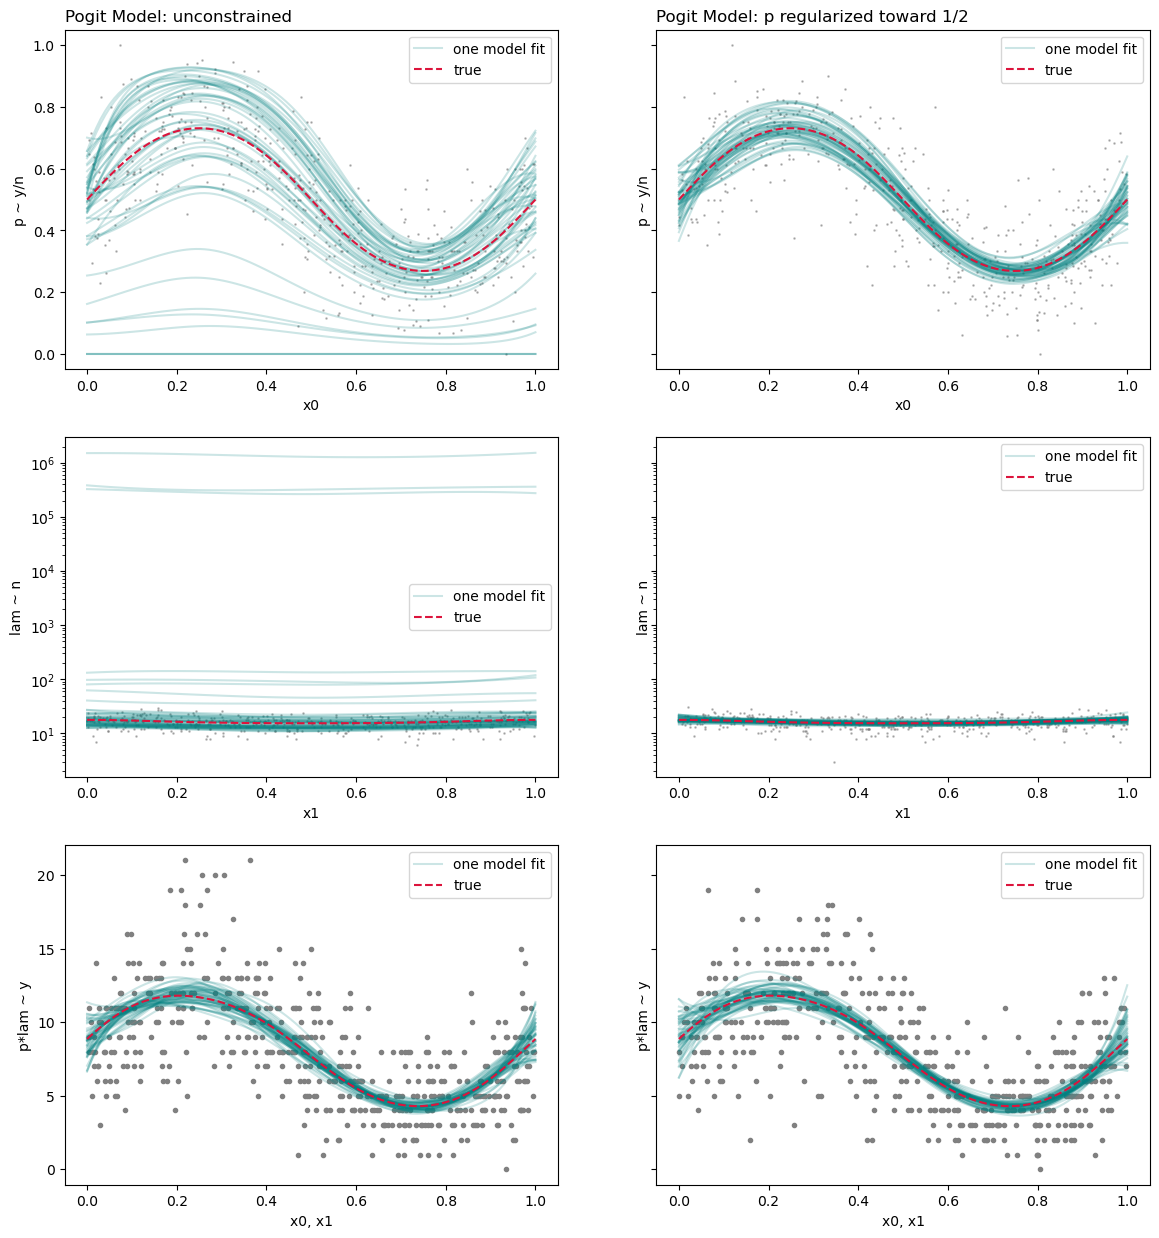

In [13]:
plotComparison([(unconstrainedPred0, unconstrainedPred1, ": unconstrained"),
                (regularizedPred0, regularizedPred1, ": p regularized toward 1/2")])

## Technique 2: Linear Constraints

We force lambda to be fit as a convex function of x1. Note that this is only an approximation of the truth; in reality lambda is close to convex, but not quite.

In [14]:
def var1_gen_convex(x0):
    # Build a new x1 variable that enforces the convexity constraint
    uniform_prior_avgLam_cvx = SplineUniformPrior(domain_lb=0,
                                            domain_ub=1,
                                            size=50,
                                            lb=0.0,
                                            ub=np.inf,
                                            domain_type="abs",
                                            order=2)

    var1 = SplineVariable(name="x1",
                          spline_specs=SplineSpecs(knots=np.array([0.0, 0.25, 0.75, 1.0]),
                                                   knots_type="abs",
                                                   degree=3),
                          linear_upriors=[uniform_prior_avgLam_cvx])
    
    return var1

def var0_gen_convex(x0):
    # Build a new x0 variable that enforces the convexity constraint on the second half
    uniform_prior_avgP_cvx = SplineUniformPrior(domain_lb=0.5,
                                            domain_ub=1,
                                            size=50,
                                            lb=0.0,
                                            ub=np.inf,
                                            domain_type="abs",
                                            order=2)

    var0 = SplineVariable(name="x0",
                          spline_specs=SplineSpecs(knots=np.array([0.0, 0.25, 0.75, 1.0]),
                                                   knots_type="abs",
                                                   degree=3),
                          linear_upriors=[uniform_prior_avgP_cvx])
    
    return var0

def var0_gen_concave(x0):
    # Build a new x0 variable that enforces concavity in the first half
    uniform_prior_avgP_ccv = SplineUniformPrior(domain_lb=0,
                                            domain_ub=0.5,
                                            size=50,
                                            lb=-1*np.inf,
                                            ub=0,
                                            domain_type="abs",
                                            order=2)

    var0 = SplineVariable(name="x0",
                          spline_specs=SplineSpecs(knots=np.array([0.0, 0.25, 0.75, 1.0]),
                                                   knots_type="abs",
                                                   degree=3),
                          linear_upriors=[uniform_prior_avgP_ccv])
    
    return var0

def var0_gen_concave_convex(x0):
    # Build a new x0 variable that enforces concavity in the first half
    uniform_prior_avgP_ccv = SplineUniformPrior(domain_lb=0,
                                            domain_ub=0.5,
                                            size=50,
                                            lb=-1*np.inf,
                                            ub=0,
                                            domain_type="abs",
                                            order=2)
    
    uniform_prior_avgP_cvx = SplineUniformPrior(domain_lb=0.5,
                                            domain_ub=1,
                                            size=50,
                                            lb=0.0,
                                            ub=np.inf,
                                            domain_type="abs",
                                            order=2)


    var0 = SplineVariable(name="x0",
                          spline_specs=SplineSpecs(knots=np.array([0.0, 0.25, 0.75, 1.0]),
                                                   knots_type="abs",
                                                   degree=3),
                          linear_upriors=[uniform_prior_avgP_ccv, uniform_prior_avgP_cvx])
    
    return var0

In [15]:
pred0_a, pred1_a = fitModel(var0_gen_concave_convex, var1_gen_convex)

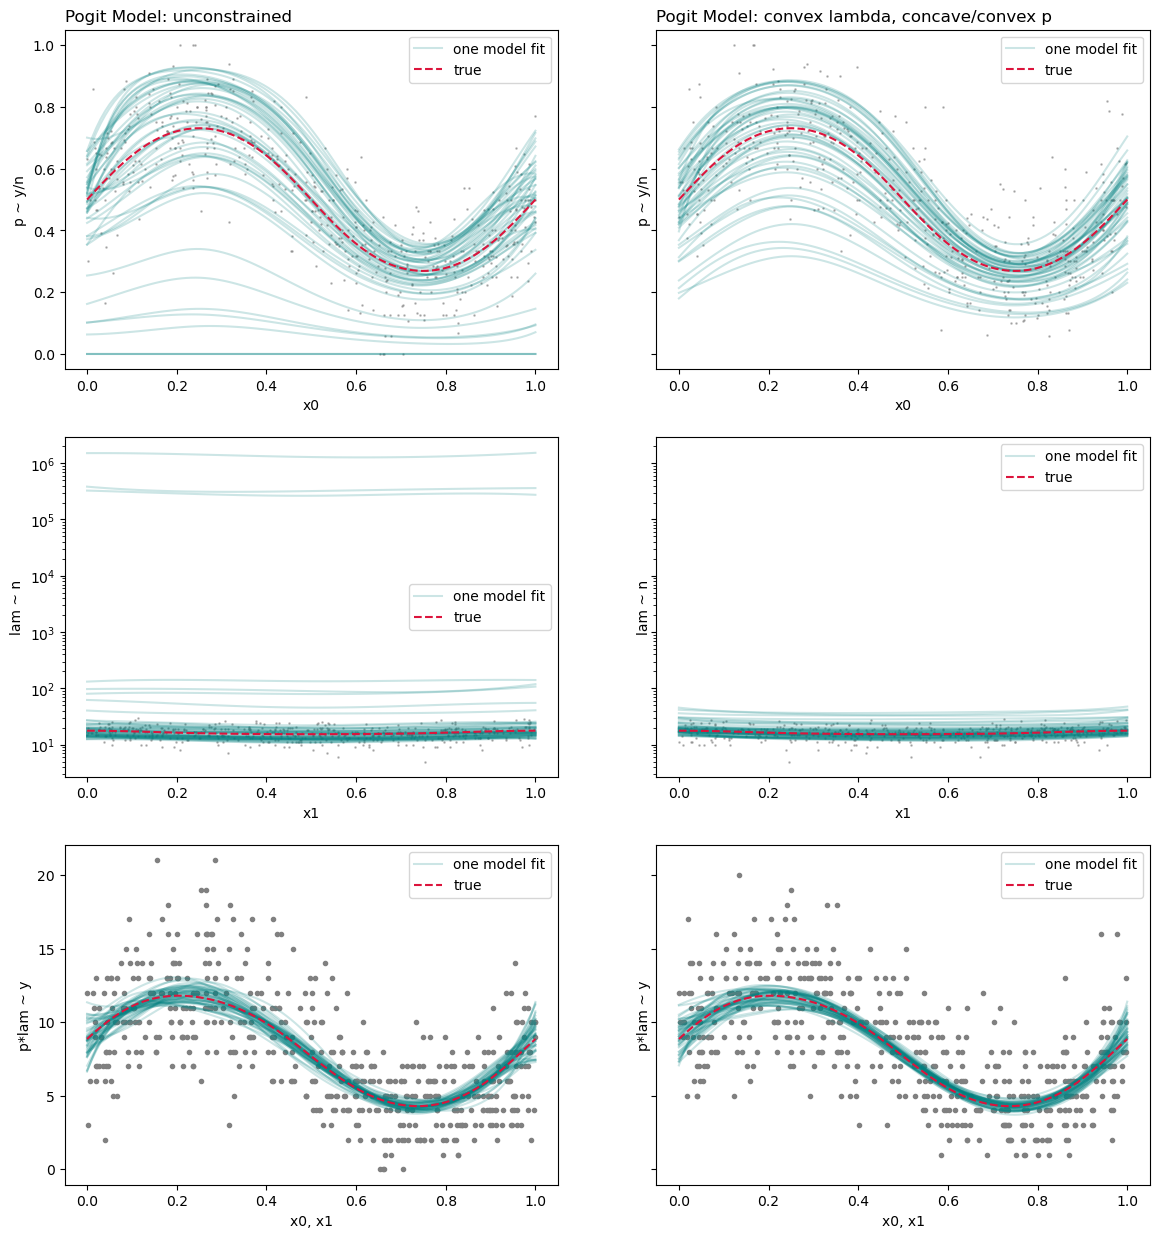

In [16]:
plotComparison([(unconstrainedPred0, unconstrainedPred1, ": unconstrained"),
                (pred0_a, pred1_a, ": convex lambda, concave/convex p")])

# Technique 3: Modify the Link Function

Suppose we knew that `p` only took values between `0.2` and `0.8`. We modify the inverse link function to be

`l(x) = 0.2 + (0.8 - 0.2)/(1 + exp(-x)`

In [17]:
from regmod.function import SmoothFunction
from regmod.function import expit_fun, expit_dfun, expit_d2fun

def create_texpit(a, b):
    """Create truncated expit function"""
    def texpit_fun(x, a=a, b=b):
        return a + (b-a)*expit_fun(x)
    
    def texpit_dfun(x, a=a, b=b):
        return (b-a)*expit_dfun(x)
        
    def texpit_d2fun(x, a=a, b=b):
        return (b-a)*expit_d2fun(x)
        
    return SmoothFunction(name="texpit", fun=texpit_fun, dfun=texpit_dfun, d2fun=texpit_d2fun)

# def create_texpit(a, b):
#     """Create truncated expit function"""
#     def texpit_fun(x, a=a, b=b):
#         return a + (b-a)/(1 + np.exp(-1*x))
    
#     def texpit_dfun(x, a=a, b=b):
#         return np.exp(-1*x) * (b-a) / (np.exp(-1*x) + 1)**2
        
#     def texpit_d2fun(x, a=a, b=b):
#         return np.exp(x) * (np.exp(x) - 1) * (a-b) / (1 + np.exp(x))**3
        
#     return SmoothFunction(name="texpit", fun=texpit_fun, dfun=texpit_dfun, d2fun=texpit_d2fun)

In [18]:
texpit = create_texpit(0.2, 0.8)

texpitPred0, texpitPred1 = fitModel(var0_gen_unconstrained, var1_gen_unconstrained, pOptions={"inv_link": texpit})

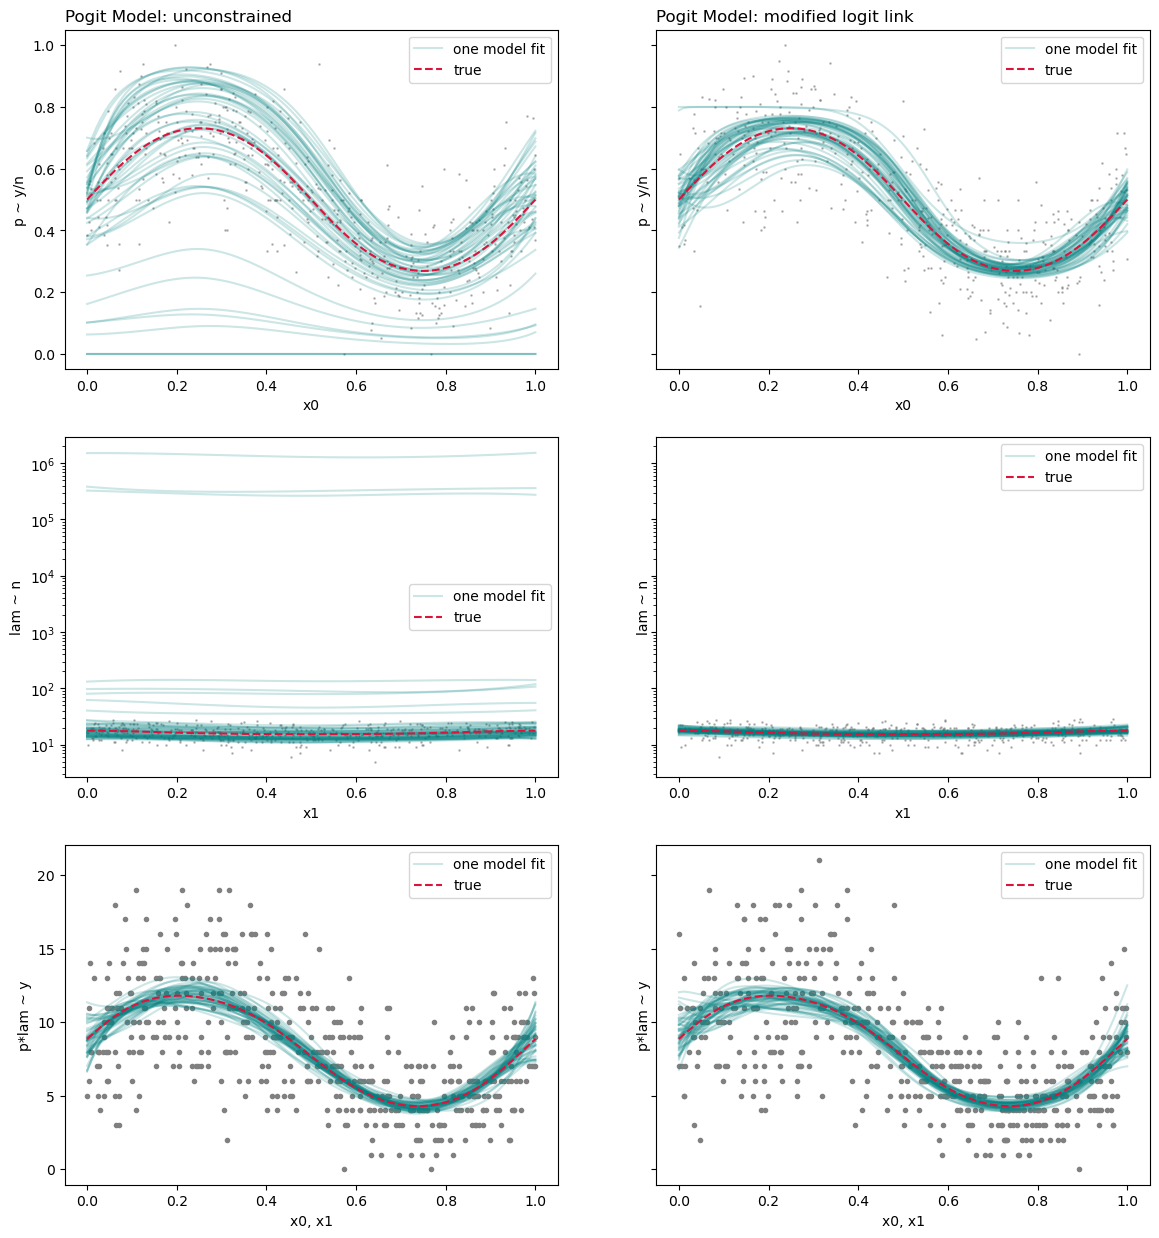

In [19]:
plotComparison([(unconstrainedPred0, unconstrainedPred1, ": unconstrained"),
                (texpitPred0, texpitPred1, ": modified logit link")])

## Plot all techniques together, to compare

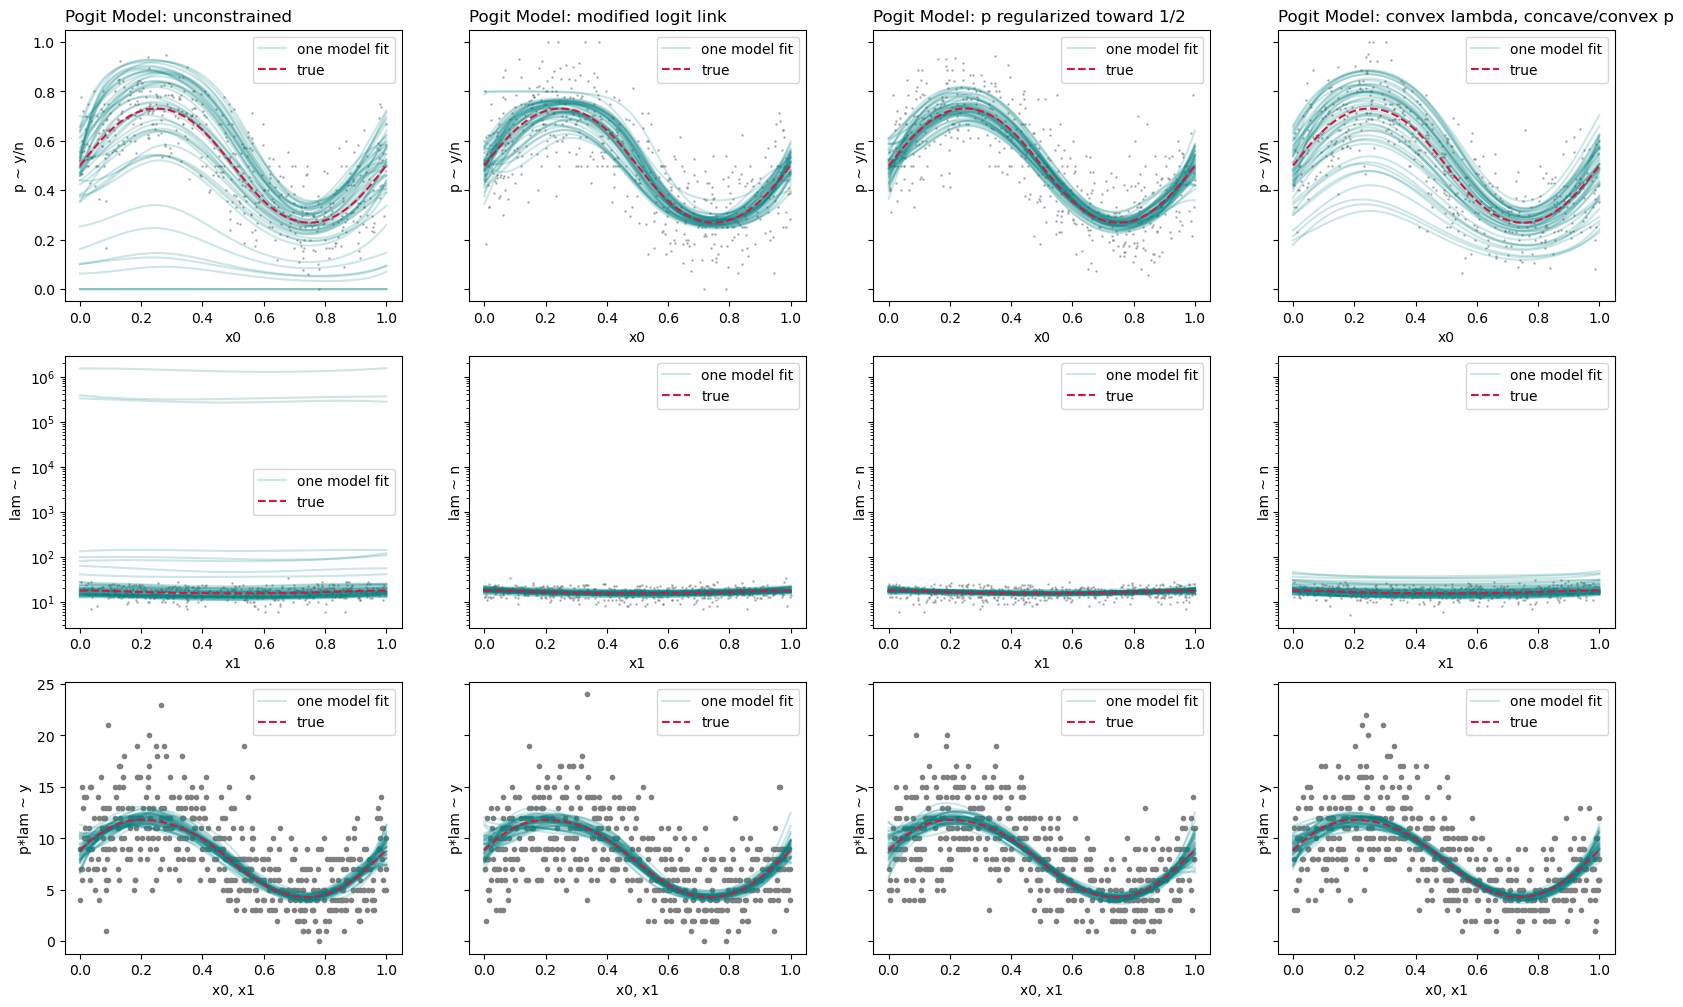

In [20]:
plotComparison([(unconstrainedPred0, unconstrainedPred1, ": unconstrained"),
                (texpitPred0, texpitPred1, ": modified logit link"),
                (regularizedPred0, regularizedPred1, ": p regularized toward 1/2"),
                (pred0_a, pred1_a, ": convex lambda, concave/convex p")],
              saveFile="constraintComparisons_nObs"+str(NUM_OBS)+".pdf",
               #subplotDims=(7,5)
               subplotDims=(5,4)
              )